# Prepare atmosperic data

Read data from atmospheric reanalysis and prepare csv files with specific data requiered to study sea level along the coast of the Netherlands

__Data required to run the notebook:__

- __Tide gauge data__ can be downloaded on the [PSMSL website](https://www.psmsl.org/) with this link:

https://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip

- The __ERA5 wind and pressure__ can be downloaded from:

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means-preliminary-back-extension?tab=overview (1950-1958)

and 

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview (1959-present)

Three variables are necessary:
10m u-component of wind, 10m v-component of wind, Mean sea level pressure

__Warning__: The code expects the data to be stored in 6 files called:

'ERA5_be_u10.nc', 'ERA5_u10.nc',
'ERA5_be_v10.nc', 'ERA5_v10.nc',
'ERA5_be_msl.nc', 'ERA5_msl.nc'

Where the backward extension data (1950-1978) is indicated with 'be' and other files cover 1979-now.

- The __20th Century Reanalysis__ data is available there:

https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.monolevel.html#caveat

Three necessary files:

u wind 10m, Monthly Mean SI-MO (https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/10mSI-MO/uwnd.10m.mon.mean.nc)

v wind 10m, Monthly Mean SI-MO (https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/10mSI-MO/vwnd.10m.mon.mean.nc)

Mean Sea Level Pressure at Mean Sea Level, Monthly Mean SI-MO (https://downloads.psl.noaa.gov/Datasets/20thC_ReanV3/Monthlies/miscSI-MO/prmsl.mon.mean.nc)

__Environment required to run the notebook:__

An installation of Python 3.9 with recent versions of the libraries (numpy, matplotlib, pandas, xarray) should run this Notebook wihout modification.

In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr


In [2]:
# For higher resolution images on retina display screens

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [3]:
# Set paths

path_data = '/Users/sbult/Desktop/Scripts/data/'
path_era5_data = f'{path_data}/ERA5/'
path_20cr_data = f'{path_data}/20CR/'

output_dir = '/Users/sbult/Desktop/Scripts/data/data_atmosphere/'

## Choose a region
The notebook was only tested for the Netherlands and Belgium but other regions can be defined here using the tide gauge ids used by the PSMSL data.

For the Netherlands the six main tide gauge with reliable data since 1890 are used.
For Belgium three tide gauges are used (Nieuwpoort, Oostende, Zeebrugge) but unfortunately they only have data since 1967.

In [4]:
region = 'Netherlands'

if region == 'Netherlands':
    tg_id = [20, 22, 23, 24, 25, 32]
elif region == 'Belgium':
    tg_id = [489, 413, 470]
elif region == 'Others':
    tg_id = [1,202,47,7,52,80,58,95,70,2]
elif region == 'Pacific':
    tg_id = [225]

## Define wind functions

In [5]:
rho_o = 1030 # Density of ocean water
g = 9.81 # Acceleration of gravity

def find_closest(lat, lon, lat_i, lon_i):
    """lookup the index of the closest lat/lon"""
    Lon, Lat = np.meshgrid(lon, lat)
    idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
    Lat.ravel()[idx], Lon.ravel()[idx]
    [i, j] = np.unravel_index(idx, Lat.shape)
    return i, j

def make_wind_df(lat_i, lon_i, product):
    """Create a wind dataset at one lat/lon location.
    Work for NCEP1 (1948-now), ERA5 (1950-now), 20CR (1936-2015)."""
    
    if product == 'NCEP1':
        # Use for OpenDAP:
        #NCEP1 = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/'
        #For local:
        NCEP1_dir = PATH_SLBudgets_data + 'WindPressure/NCEP1/'
        u_file = NCEP1_dir + 'uwnd.10m.mon.mean.nc'
        v_file = NCEP1_dir + 'vwnd.10m.mon.mean.nc'
        p_file = NCEP1_dir + 'pres.sfc.mon.mean.nc'
        latn = 'lat'
        lonn = 'lon'
        timen = 'time'
        un = 'uwnd'
        vn = 'vwnd'
        pn = 'pres'
        
    elif product == 'ERA5':
        ERA5_dir = path_era5_data 
        u_file = [ERA5_dir + 'ERA5_u10.nc']
        v_file = [ERA5_dir + 'ERA5_v10.nc']
        p_file = [ERA5_dir + 'ERA5_msl.nc']
        # u_file = [ERA5_dir + 'ERA5_u10_19401969.nc', ERA5_dir + 'ERA5_u10_19701999.nc', ERA5_dir + 'ERA5_u10_20002021.nc']
        # v_file = [ERA5_dir + 'ERA5_v10_19401969.nc', ERA5_dir + 'ERA5_v10_19701999.nc', ERA5_dir + 'ERA5_v10_20002021.nc']
        # p_file = [ERA5_dir + 'ERA5_msl_19401969.nc', ERA5_dir + 'ERA5_msl_19701999.nc', ERA5_dir + 'ERA5_msl_20002021.nc']
        latn = 'latitude'
        lonn = 'longitude'
        timen = 'time'
        un = 'u10'
        vn = 'v10'
        pn = 'msl'
    
    elif product == '20CR':
        TCR_dir = path_20cr_data
        u_file = TCR_dir + 'uwnd.10m.mon.mean.nc'
        v_file = TCR_dir + 'vwnd.10m.mon.mean.nc'
        p_file = TCR_dir + 'prmsl.mon.mean.nc'
        latn = 'lat'
        lonn = 'lon'
        timen = 'time'
        un = 'uwnd'
        vn = 'vwnd'
        pn = 'prmsl'
    
    if lon_i < 0:
        lon_i = lon_i + 360
    
    # open the 3 files
    ds_u = xr.open_mfdataset(u_file)
    ds_v = xr.open_mfdataset(v_file)
    ds_p = xr.open_mfdataset(p_file)
    
    if product == 'ERA5':
        ds_u = rotate_longitude(ds_u, lonn)
        ds_v = rotate_longitude(ds_v, lonn)
        ds_p = rotate_longitude(ds_p, lonn)
        
    if product == '20CR':
        ds_u = ds_u.load()
        ds_v = ds_v.load()
        ds_p = ds_p.load()
    
    # read lat, lon, time from 1 dataset
    lat, lon = ds_u[latn][:], ds_u[lonn][:]
    
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon, lat_i, lon_i)
    
    # get the u, v, p variables
    print('found point', float(lat[i]), float(lon[j]))    
    u = ds_u[un][:, i, j]
    v = ds_v[vn][:, i, j]
    pres = ds_p[pn][:, i, j]
    pres = pres - pres.mean()
    
    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # Inverse barometer effect in cm
    ibe = - pres/(rho_o*g)*100
    ibe = ibe - ibe.mean()
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # Compute the wind squared while retaining sign, as an approximation of stress
    wind_magnitude = np.sqrt(u**2 + v**2)
    u2 = wind_magnitude*u
    v2 = wind_magnitude*v
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=u[timen], speed=speed, direction=direction, u2=u2, v2=v2, 
                                    pres=pres, ibe=ibe))
    wind_df = wind_df.set_index('t')
    
    annual_wind_df = wind_df.groupby(wind_df.index.year).mean()
    
    
    return annual_wind_df, float(lat[i]), float(lon[j])

In [6]:
def rotate_longitude(ds, name_lon):

    ds = ds.assign_coords({'longitude':(((ds['longitude'] + 360 ) % 360))})
    ds = ds.sortby(ds[name_lon])

    return ds

In [7]:
#(ds['longitude'] + 360 ) % 360

In [8]:
ERA5_dir = path_era5_data 
u_file = [ERA5_dir + 'ERA5_u10.nc']
v_file = [ERA5_dir + 'ERA5_v10.nc']
ds_u = xr.open_mfdataset(u_file)
ds_v = xr.open_mfdataset(v_file)

In [9]:
#ds_u.where(ds_u.longitude<0, )
ds = rotate_longitude(ds_u, 'longitude')
ds2 = rotate_longitude(ds_v, 'longitude')

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


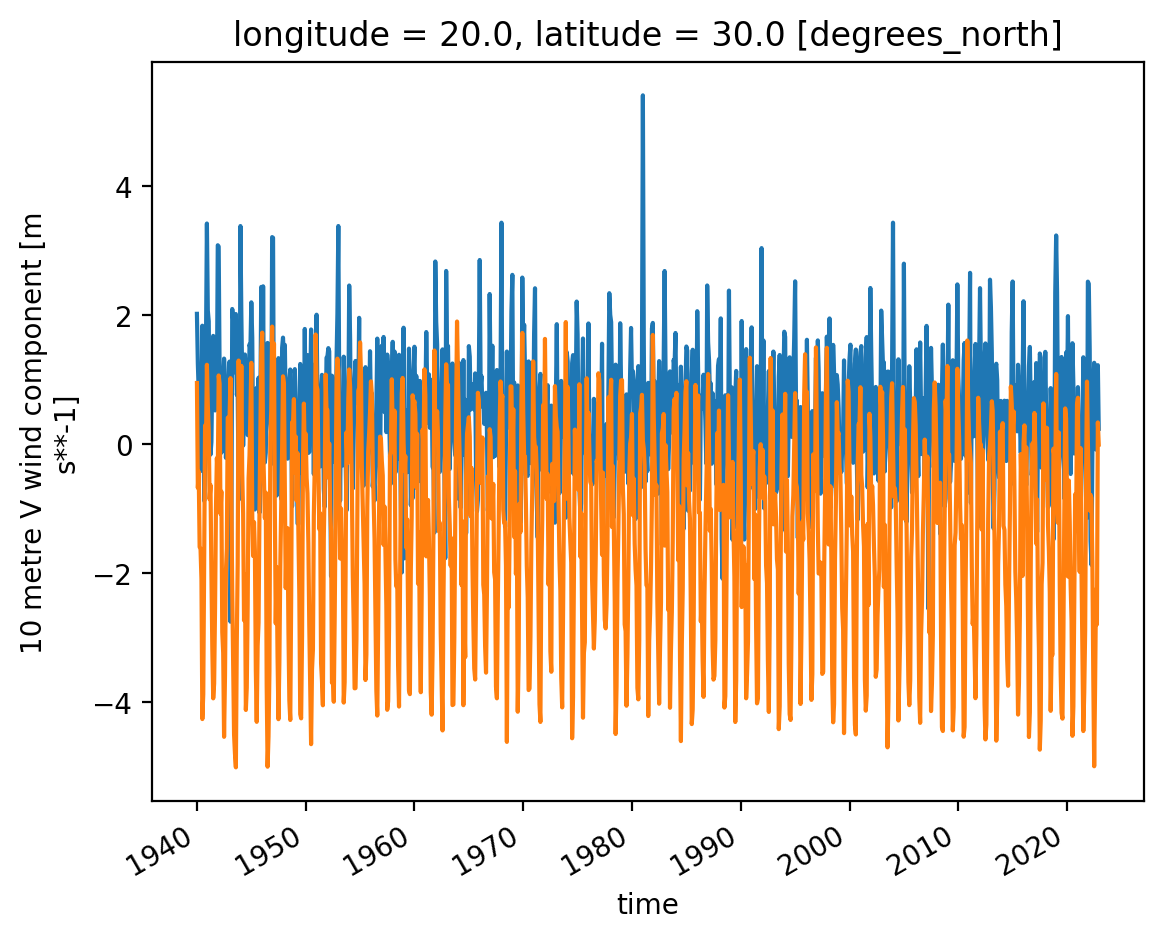

In [10]:
one = ds.sel(longitude=35, latitude=-11, method='nearest')
two = ds2.sel(longitude=35, latitude=-11, method='nearest')
one.u10.plot()
two.v10.plot()

In [11]:
TCR_dir = path_20cr_data
u_file = TCR_dir + 'uwnd.10m.mon.mean.nc'
ds_u = xr.open_mfdataset(u_file)

In [12]:
ds_u.sel(longitude=-19.75, latitude=64.8, method='nearest')

KeyError: 'longitude is not a valid dimension or coordinate'

## Test the wind functions

In [13]:
lat = 50
lon = 13

test_era5 = make_wind_df(lat,lon, 'ERA5')
test_20cr = make_wind_df(lat,lon, '20CR')

test_era5

found point 50.0 13.0
found point 50.0 13.0


(             u         v     speed  direction        u2        v2        pres  \
 t                                                                               
 1940  1.259397 -0.224799  1.735734   3.029309  3.085782 -0.103040   86.417969   
 1941  1.050534 -0.432793  1.585978   3.854525  2.530142 -0.430346  -31.340494   
 1942  0.773835 -0.181474  1.223191   3.469324  1.403218 -0.057533  128.014328   
 1943  0.998201 -0.045779  1.462745   3.503442  2.275281  0.151526  208.538406   
 1944  1.123099 -0.138792  1.501018   3.567327  3.089687  0.045729   76.080078   
 ...        ...       ...       ...        ...       ...       ...         ...   
 2018  0.233026 -0.299264  1.229961   3.598500  0.420525 -0.325589    7.498698   
 2019  1.126168  0.018532  1.646995   2.265834  2.528493  0.101554  -57.351562   
 2020  1.179598  0.180120  1.406961   3.601503  2.898823  0.760876   83.105469   
 2021  1.321972 -0.041209  1.429612   3.489857  2.270122  0.033763   64.362633   
 2022  1.055827 

In [14]:
test_era5.u2.plot(label='ERA5')
test_20cr.u2.plot(label='20CR')

plt.legend()
plt.ylabel('sign(U)*U [m/s]')
plt.title(f'Wind velocity at {lat}º latitude, {lon}º longitude')

#plt.savefig('WindComparison_20CR_ERA5.pdf', dpi=150)

AttributeError: 'tuple' object has no attribute 'u2'

## Export wind data for individual tide gauges

Also create a dataframe containing the locations of the tide gauge stations and reanalysis datasets

In [17]:
def tg_lat_lon(tg_id):
    '''Return tide gauge latitude, longitude location given the id as input'''
    
    tg_data_dir = path_data + 'tide gauges/rlr_annual'
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')
    
    return filelist_df.loc[tg_id].lat, filelist_df.loc[tg_id].lon


In [18]:
# stations = ['Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']
stations = ['Brest','Newlyn','Stavanger','Cuxhaven','Cascais','Esbjerg','Bergen','North Shields','Kungsholmsfort','Swinoujscie','Ketchikan']

for reanalysis in ['ERA5', '20CR']:
    lats = []
    lons = []
    tg_lats = []
    tg_lons = []
    
    for i in range( len(tg_id)):
        tg_lat, tg_lon = tg_lat_lon(tg_id[i])
        
        if reanalysis == 'ERA5':
            tg_lats.append(tg_lat)
            tg_lons.append(tg_lon)
        
        wind_df, lat, lon = make_wind_df(tg_lat, tg_lon, reanalysis)

        wind_df.to_csv(f'{output_dir}/wind_data_{reanalysis}_tg{tg_id[i]}.csv')
        
        lats.append(lat)
        lons.append(lon)
        
    #if reanalysis == 'ERA5':   
     #   pd.DataFrame({'station': stations, 'lat': tg_lats, 'lon': tg_lons}).set_index('station').to_csv('/Users/sbult/Desktop/Scripts/data/data_atmosphere/outputs/tg_coords.csv')
    
    #pd.DataFrame({'station': stations, 'lat': lats, 'lon': lons}).set_index('station').to_csv(f'/Users/sbult/Desktop/Scripts/data/data_atmosphere/outputs/{reanalysis}_coords.csv')
    
    

found point 51.5 3.5
found point 52.0 4.0
found point 53.0 4.75
found point 53.25 7.0
found point 53.25 5.5
found point 52.5 4.5
found point 51.0 4.0
found point 52.0 4.0
found point 53.0 5.0
found point 53.0 7.0
found point 53.0 5.0
found point 52.0 5.0


In [19]:
print(tg_id)

[20, 22, 23, 24, 25, 32]


In [20]:
lons

[4.0, 4.0, 5.0, 7.0, 5.0, 5.0]

In [21]:
lats = np.arange(30,71,1)
lons = np.arange(-20,21,1)
tg_id = np.zeros((len(lats),len(lons),2))

for i in range(len(lats)):
    for j in range(len(lons)):
        tg_id[i,j,:] = lats[i], lons[j]

In [22]:
tg_id = np.reshape(tg_id,[1681,2])

In [23]:
for reanalysis in ['ERA5', '20CR']:
    lats = []
    lons = []
    tg_lats = []
    tg_lons = []
    
    for i in range(len(tg_id)):
        tg_lat, tg_lon = tg_id[i,:]
        
        if reanalysis == 'ERA5':
            tg_lats.append(tg_lat)
            tg_lons.append(tg_lon)
        
        wind_df, lat, lon = make_wind_df(tg_lat, tg_lon, reanalysis)

        wind_df.to_csv(f'{output_dir}/wind_data_{reanalysis}_lat{tg_id[i,0]}_lon{tg_id[i,1]}.csv')
        
        lats.append(lat)
        lons.append(lon)
        
    #if reanalysis == 'ERA5':   
     #   pd.DataFrame({'station': stations, 'lat': tg_lats, 'lon': tg_lons}).set_index('station').to_csv('/Users/sbult/Desktop/Scripts/data/data_atmosphere/outputs/tg_coords.csv')
    
    #pd.DataFrame({'station': stations, 'lat': lats, 'lon': lons}).set_index('station').to_csv(f'/Users/sbult/Desktop/Scripts/data/data_atmosphere/outputs/{reanalysis}_coords.csv')

found point 30.0 340.0
found point 30.0 341.0
found point 30.0 342.0
found point 30.0 343.0
found point 30.0 344.0
found point 30.0 345.0
found point 30.0 346.0
found point 30.0 347.0
found point 30.0 348.0
found point 30.0 349.0
found point 30.0 350.0
found point 30.0 351.0


KeyboardInterrupt: 